# TFT Hyperparameter Sensitivity Analysis

Study how each TFT parameter affects prediction quality on beach crowd data.
Uses a **fixed dataset split** (expanding window, Daytime sequential) and varies **one parameter at a time**.

Parameters tested:
1. **horizon** (h): 6, 12, 24, 48
2. **input_size**: 24, 48, 96, 168
3. **hidden_size**: 32, 64, 128, 256
4. **n_head**: 2, 4, 8
5. **max_steps**: 300, 750, 1500, 3000
6. **learning_rate**: 1e-4, 5e-4, 1e-3, 5e-3
7. **batch_size**: 32, 64, 128
8. **loss function**: MAE, MSE, RMSE
9. **scaler_type**: robust, standard, minmax
10. **hist vs futr exogenous** split

For PyTorch-Forecasting:
11. **QuantileLoss vs MAE**
12. **dropout**: 0.0, 0.1, 0.2, 0.3
13. **encoder length**: 24, 48, 96


In [1]:
CACHE_DIR = "cache/predictions"
COUNTING_MODEL = "bayesian_vgg19"
SAVE_DIR = "models/tft_sensitivity"

# === QUICK TEST FILTERS ===
SAMPLE_FRAC = 0.5
MAX_BEACHES = 1           # None = all, 1 = fastest test
BEACH_NAMES = ['skyline/mallorca-alcudia']        # None = auto pick, or list: ['skyline/mallorca-alcudia']

# === GPU ===
GPU_NF = 1
GPU_PF = 1

NIGHT_START = 20
NIGHT_END = 6

# Baseline parameters (will be overridden per experiment)
BASELINE = {
    'h': 24,
    'input_size': 48,
    'hidden_size': 128,
    'n_head': 4,
    'max_steps': 1500,
    'learning_rate': 1e-3,
    'batch_size': 64,
    'loss': 'MAE',
    'scaler_type': 'robust',
}
print("Baseline:", BASELINE)


Baseline: {'h': 24, 'input_size': 48, 'hidden_size': 128, 'n_head': 4, 'max_steps': 1500, 'learning_rate': 0.001, 'batch_size': 64, 'loss': 'MAE', 'scaler_type': 'robust'}


In [2]:
import subprocess, sys
for pkg in ["neuralforecast", "utilsforecast", "pytorch-forecasting", "pytorch_optimizer"]:
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])


In [3]:
import json, time, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')

import torch
from neuralforecast import NeuralForecast
from neuralforecast.models import TFT
from neuralforecast.losses.pytorch import MAE, MSE, RMSE

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE as PF_MAE, QuantileLoss

if torch.cuda.is_available():
    n_gpus = torch.cuda.device_count()
    ACCELERATOR = 'gpu'
    NF_DEVICES = [1] if n_gpus > 1 else [0]
    PF_DEVICES = [GPU_PF] if n_gpus > 1 else [0]
    for i in range(n_gpus):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    ACCELERATOR = 'mps'
    NF_DEVICES = [0]
    PF_DEVICES = [0]
else:
    ACCELERATOR = 'cpu'
    NF_DEVICES = [0]
    PF_DEVICES = [0]

print(f"Accelerator: {ACCELERATOR} | NF GPU: {NF_DEVICES} | PF GPU: {PF_DEVICES}")

save_dir = Path(SAVE_DIR)
save_dir.mkdir(parents=True, exist_ok=True)


Accelerator: mps | NF GPU: [0] | PF GPU: [0]


In [4]:
def calc_metrics(y_true, y_pred, max_count):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    rel_mae = (mae / max_count) * 100 if max_count > 0 else 0
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'RelMAE': rel_mae}


## Load and Prepare Data

In [5]:
def load_cache(cache_dir, model):
    cache_path = Path(cache_dir) / model
    records = []
    for jf in cache_path.rglob("*.json"):
        try:
            with open(jf) as f:
                r = json.load(f)
            if 'error' not in r:
                records.append(r)
        except: pass
    rows = []
    for r in records:
        row = {
            'beach': r.get('beach') or r.get('beach_folder'),
            'beach_folder': r.get('beach_folder'),
            'datetime': r.get('datetime'),
            'count': r.get('count')
        }
        for k, v in r.get('weather', {}).items():
            row[k] = v
        rows.append(row)
    df = pd.DataFrame(rows)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime').reset_index(drop=True)
    return df

df_raw = load_cache(CACHE_DIR, COUNTING_MODEL)
print(f"Loaded: {len(df_raw)} rows, {df_raw['beach'].nunique()} beaches")


Loaded: 169241 rows, 41 beaches


In [6]:
EXCLUDE = ['livecampro/001', 'livecampro/011', 'livecampro/018', 'livecampro/021',
    'livecampro/030', 'livecampro/039', 'livecampro/070', 'MultimediaTres/PortAndratx',
    'SeeTheWorld/mallorca_pancam', 'skyline/es-pujols']
EXCLUDE_PREFIX = ['ibred', 'ClubNauticSoller', 'Guenthoer', 'youtube']

before = len(df_raw)
df_raw = df_raw[~df_raw['beach_folder'].isin(EXCLUDE)]
for p in EXCLUDE_PREFIX:
    df_raw = df_raw[~df_raw['beach_folder'].str.startswith(p, na=False)]
print(f"Excluded: {before} -> {len(df_raw)}")

if SAMPLE_FRAC < 1.0:
    df_raw = df_raw.sample(frac=SAMPLE_FRAC, random_state=42).sort_values('datetime').reset_index(drop=True)

if BEACH_NAMES:
    df_raw = df_raw[df_raw['beach_folder'].isin(BEACH_NAMES)].reset_index(drop=True)
    print(f"Selected beaches: {BEACH_NAMES}")
elif MAX_BEACHES:
    top = df_raw['beach_folder'].value_counts().head(MAX_BEACHES).index.tolist()
    df_raw = df_raw[df_raw['beach_folder'].isin(top)].reset_index(drop=True)
    print(f"Top {MAX_BEACHES} beaches: {top}")

print(f"Final: {len(df_raw)} rows, {df_raw['beach_folder'].nunique()} beaches")


Excluded: 169241 -> 70501
Selected beaches: ['skyline/mallorca-alcudia']
Final: 1840 rows, 1 beaches


In [7]:
df = df_raw.copy()
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
df['is_night'] = ((df['hour'] >= NIGHT_START) | (df['hour'] <= NIGHT_END)).astype(int)

WEATHER_COLS = [c for c in df.columns if c.startswith('ae_') or c.startswith('om_')]
TEMPORAL_COLS = ['hour', 'day_of_week', 'month', 'is_weekend', 'is_summer', 'is_night']
ALL_FEATURES = WEATHER_COLS + TEMPORAL_COLS

df = df.dropna(subset=ALL_FEATURES + ['count']).reset_index(drop=True)
good = df.groupby('beach')['count'].max()
good = good[good > 20].index.tolist()
df = df[df['beach'].isin(good)].reset_index(drop=True)

print(f"After cleaning: {len(df)} rows, {len(good)} beaches")
print(f"Weather features: {len(WEATHER_COLS)} | Temporal: {len(TEMPORAL_COLS)}")


After cleaning: 1828 rows, 1 beaches
Weather features: 29 | Temporal: 6


### Data Exploration

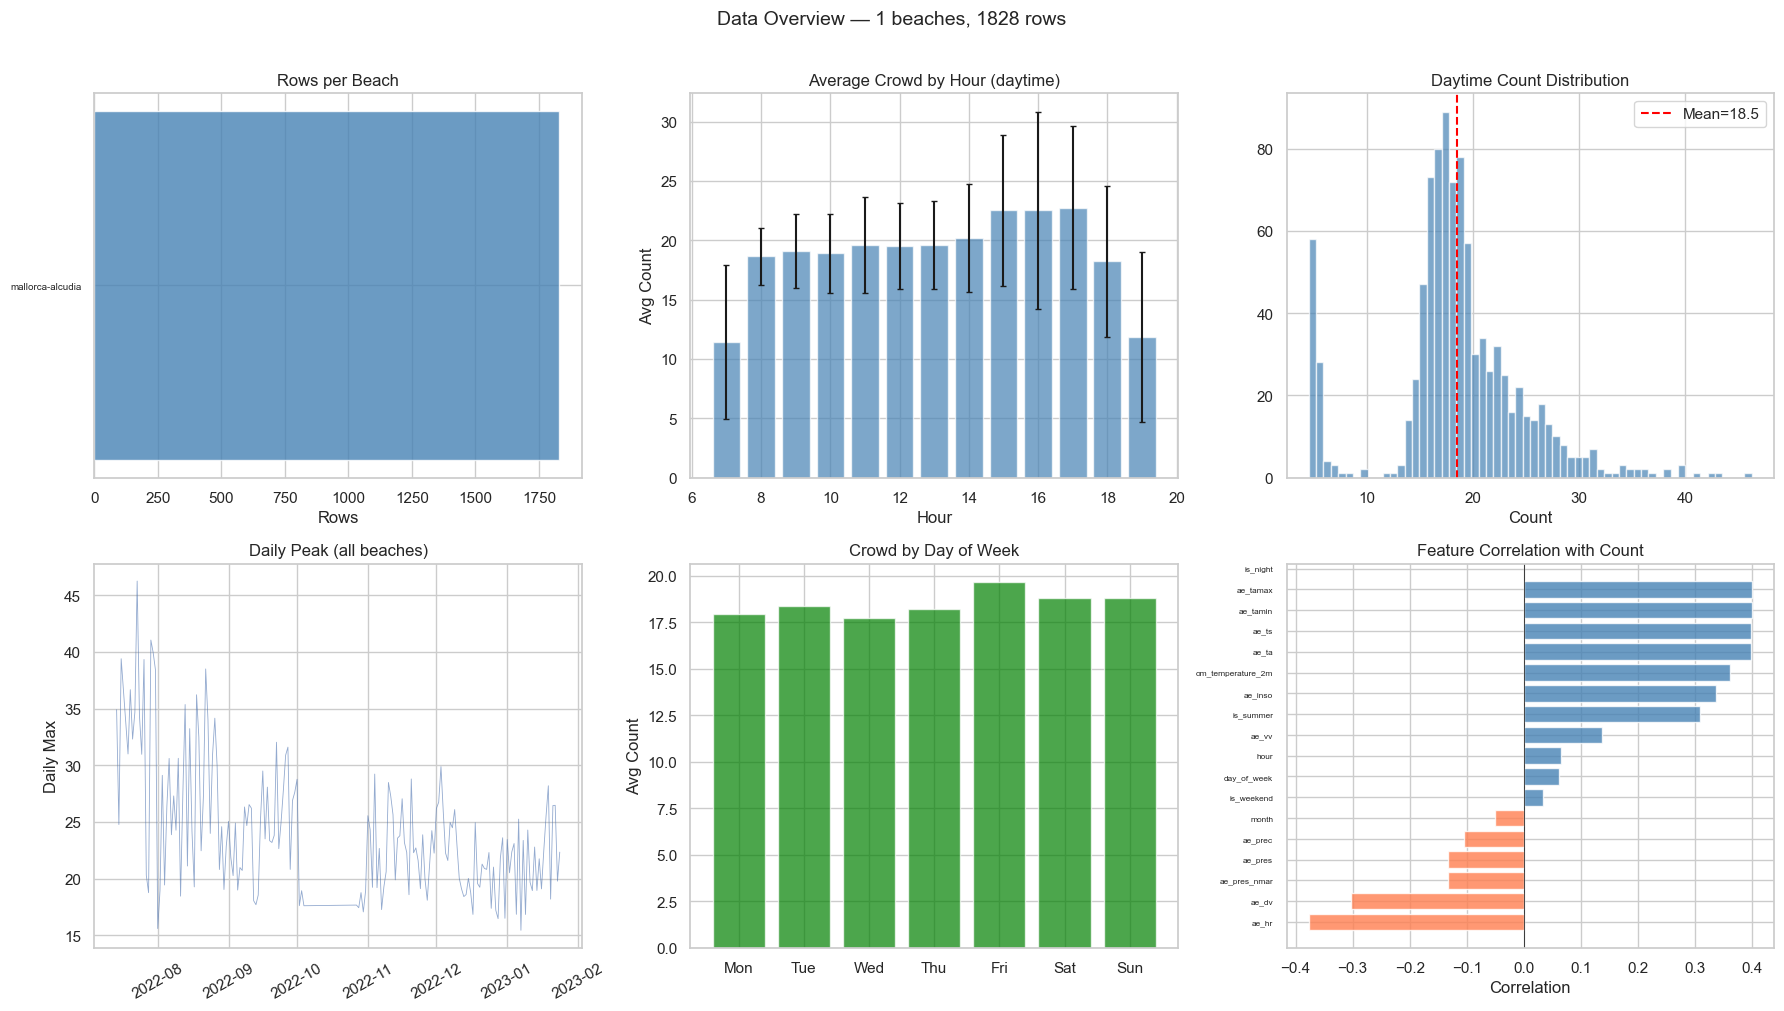

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Rows per beach
bc = df.groupby('beach_folder').size().sort_values(ascending=True)
axes[0,0].barh(range(len(bc)), bc.values, color='steelblue', alpha=0.8)
axes[0,0].set_yticks(range(len(bc)))
axes[0,0].set_yticklabels([b.split('/')[-1][:18] for b in bc.index], fontsize=7)
axes[0,0].set_xlabel('Rows')
axes[0,0].set_title('Rows per Beach')

# 2. Hourly crowd pattern
hourly = df[df['is_night'] == 0].groupby('hour')['count'].agg(['mean', 'std'])
axes[0,1].bar(hourly.index, hourly['mean'], yerr=hourly['std'], color='steelblue', alpha=0.7, capsize=2)
axes[0,1].set_xlabel('Hour'); axes[0,1].set_ylabel('Avg Count')
axes[0,1].set_title('Average Crowd by Hour (daytime)')

# 3. Count distribution
axes[0,2].hist(df[df['is_night'] == 0]['count'], bins=60, color='steelblue', alpha=0.7, edgecolor='white')
axes[0,2].axvline(df[df['is_night'] == 0]['count'].mean(), color='red', linestyle='--', label=f"Mean={df[df['is_night']==0]['count'].mean():.1f}")
axes[0,2].set_xlabel('Count'); axes[0,2].set_title('Daytime Count Distribution'); axes[0,2].legend()

# 4. Daily max over time
daily = df[df['is_night'] == 0].groupby([df['datetime'].dt.date, 'beach_folder'])['count'].max().reset_index()
daily.columns = ['date', 'beach', 'max_count']
daily['date'] = pd.to_datetime(daily['date'])
for beach in daily['beach'].unique():
    sub = daily[daily['beach'] == beach]
    axes[1,0].plot(sub['date'], sub['max_count'], linewidth=0.6, alpha=0.6)
axes[1,0].set_ylabel('Daily Max'); axes[1,0].set_title('Daily Peak (all beaches)')
axes[1,0].tick_params(axis='x', rotation=30)

# 5. Day of week pattern
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow = df[df['is_night'] == 0].groupby('day_of_week')['count'].mean()
axes[1,1].bar([dow_names[i] for i in dow.index], dow.values, color='green', alpha=0.7)
axes[1,1].set_ylabel('Avg Count'); axes[1,1].set_title('Crowd by Day of Week')

# 6. Feature correlations
feat_corr = df[df['is_night'] == 0][['count'] + WEATHER_COLS[:12] + TEMPORAL_COLS].corr()['count'].drop('count').sort_values()
colors = ['coral' if v < 0 else 'steelblue' for v in feat_corr.values]
axes[1,2].barh(range(len(feat_corr)), feat_corr.values, color=colors, alpha=0.8)
axes[1,2].set_yticks(range(len(feat_corr)))
axes[1,2].set_yticklabels(feat_corr.index, fontsize=6)
axes[1,2].set_xlabel('Correlation'); axes[1,2].set_title('Feature Correlation with Count')
axes[1,2].axvline(0, color='black', linewidth=0.5)

plt.suptitle(f"Data Overview — {df['beach_folder'].nunique()} beaches, {len(df)} rows", fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig(save_dir / 'data_overview.png', dpi=150)
plt.show()


## Prepare Fixed Dataset for All Experiments

Use Daytime-only data with sequential integer index. Split: first 60% train, next 20% val, last 20% test.

In [9]:
from utilsforecast.preprocessing import fill_gaps

df_day = df[df['is_night'] == 0].copy()
df_day = df_day.sort_values(['beach_folder', 'datetime']).reset_index(drop=True)

# Fixed chronological split per beach
def split_data(df_in, train_frac=0.6, val_frac=0.2):
    trains, vals, tests = [], [], []
    for uid, grp in df_in.groupby('beach_folder'):
        grp = grp.sort_values('datetime')
        n = len(grp)
        tr_end = int(n * train_frac)
        va_end = int(n * (train_frac + val_frac))
        trains.append(grp.iloc[:tr_end])
        vals.append(grp.iloc[tr_end:va_end])
        tests.append(grp.iloc[va_end:])
    return pd.concat(trains), pd.concat(vals), pd.concat(tests)

train_df, val_df, test_df = split_data(df_day)
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print(f"Beaches: {train_df['beach_folder'].nunique()}")

# Prepare NF format with sequential index
def to_nf_sequential(df_in, id_col='beach_folder'):
    cols = ['datetime', id_col, 'count'] + ALL_FEATURES
    cols = [c for c in cols if c in df_in.columns]
    nf = df_in[cols].copy()
    nf = nf.rename(columns={id_col: 'unique_id', 'count': 'y'})
    nf = nf.sort_values(['unique_id', 'datetime']).reset_index(drop=True)
    nf['ds'] = nf.groupby('unique_id').cumcount()
    nf = nf.drop(columns=['datetime'])
    return nf

# Build continuous dataset (train+val+test concatenated)
all_day = pd.concat([train_df, val_df, test_df]).sort_values(
    ['beach_folder', 'datetime']).drop_duplicates(
    subset=['beach_folder', 'datetime']).reset_index(drop=True)

nf_all = to_nf_sequential(all_day)
test_size = test_df.groupby('beach_folder').size().min()

print(f"NF dataset: {len(nf_all)} rows | Test size per series: {test_size}")


Train: 566 | Val: 189 | Test: 189
Beaches: 1
NF dataset: 944 rows | Test size per series: 189


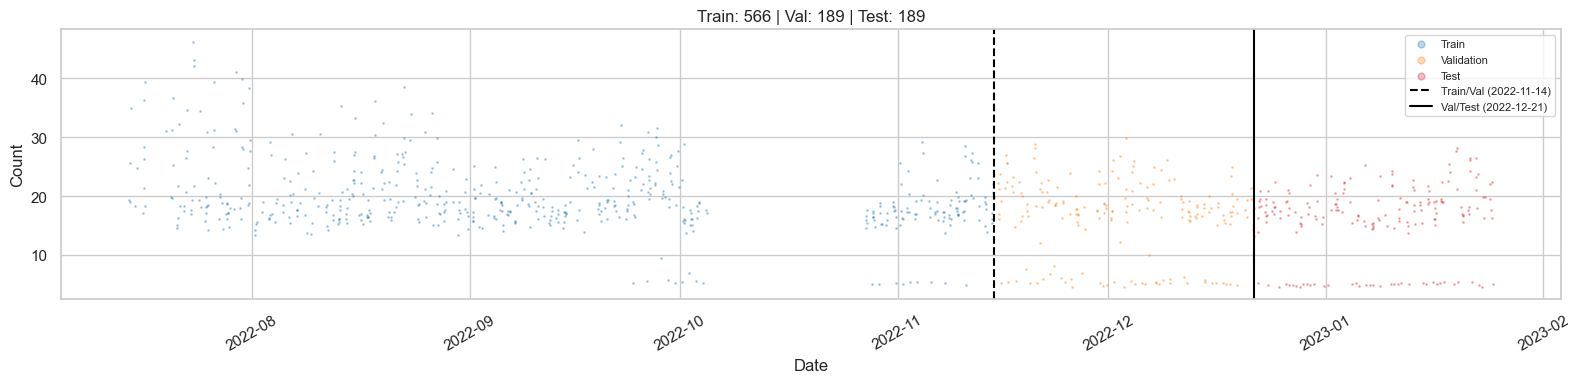

In [10]:
# Train / Val / Test split visualization
fig, ax = plt.subplots(figsize=(16, 4))
ax.scatter(train_df['datetime'], train_df['count'], s=1, alpha=0.3, c='tab:blue', label='Train')
ax.scatter(val_df['datetime'], val_df['count'], s=1, alpha=0.3, c='tab:orange', label='Validation')
ax.scatter(test_df['datetime'], test_df['count'], s=1, alpha=0.3, c='tab:red', label='Test')

split1 = val_df['datetime'].min()
split2 = test_df['datetime'].min()
ax.axvline(split1, color='black', linestyle='--', linewidth=1.5, label=f'Train/Val ({split1.date()})')
ax.axvline(split2, color='black', linestyle='-', linewidth=1.5, label=f'Val/Test ({split2.date()})')
ax.set_ylabel('Count'); ax.set_xlabel('Date')
ax.set_title(f'Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}')
ax.legend(loc='upper right', markerscale=5, fontsize=8)
ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.savefig(save_dir / 'data_split.png', dpi=150)
plt.show()


## NeuralForecast Sensitivity Runner

In [11]:
def run_nf_sensitivity(param_name, param_value, overrides=None):
    """Run one NF TFT experiment with a single parameter override."""
    params = BASELINE.copy()
    if overrides:
        params.update(overrides)
    params[param_name] = param_value

    loss_map = {'MAE': MAE(), 'MSE': MSE(), 'RMSE': RMSE()}
    loss_fn = loss_map.get(params['loss'], MAE())

    h = min(params['h'], test_size)

    try:
        t0 = time.time()
        model = TFT(
            h=h,
            input_size=params['input_size'],
            hidden_size=params['hidden_size'],
            n_head=params['n_head'],
            max_steps=params['max_steps'],
            learning_rate=params['learning_rate'],
            batch_size=params['batch_size'],
            scaler_type=params['scaler_type'],
            loss=loss_fn,
            hist_exog_list=params.get('hist_exog_list', ALL_FEATURES),
            futr_exog_list=params.get('futr_exog_list', None),
            early_stop_patience_steps=-1,
            val_check_steps=50,
            random_seed=42,
            accelerator=ACCELERATOR,
            devices=NF_DEVICES,
        )
        nf = NeuralForecast(models=[model], freq=1)
        cv = nf.cross_validation(df=nf_all, n_windows=1, step_size=h)
        elapsed = time.time() - t0

        pred_col = [c for c in cv.columns if c not in ['unique_id', 'ds', 'cutoff', 'y']][0]
        cv['pred'] = np.clip(cv[pred_col].values, 0, None)
        m = calc_metrics(cv['y'].values, cv['pred'].values, cv['y'].max())

        beach_res = []
        for b in cv['unique_id'].unique():
            bm = cv[cv['unique_id'] == b]
            if len(bm) < 3:
                continue
            bmetrics = calc_metrics(bm['y'].values, bm['pred'].values, bm['y'].max())
            beach_res.append(bmetrics)
        avg_rel = np.mean([b['RelMAE'] for b in beach_res]) if beach_res else m['RelMAE']

        result = {
            'param': param_name, 'value': param_value,
            'MAE': m['MAE'], 'RMSE': m['RMSE'], 'R2': m['R2'],
            'AvgRelMAE': avg_rel, 'Time': elapsed,
        }
        print(f"  {param_name}={param_value} | MAE={m['MAE']:.1f} | RelMAE={avg_rel:.1f}% | "
              f"R2={m['R2']:.3f} | {elapsed:.0f}s")
        return result, cv

    except Exception as e:
        print(f"  {param_name}={param_value} | ERROR: {e}")
        return None, None


## Run NF Sensitivity Experiments

Each experiment changes **one parameter** from baseline, keeping everything else fixed.

In [ ]:
sensitivity_results = []
sensitivity_preds = {}

experiments = {
    'h':             [6, 12, 24, 48],
    'input_size':    [24, 48, 96, 168],
    'hidden_size':   [32, 64, 128, 256],
    'n_head':        [2, 4, 8],
    'max_steps':     [300, 750, 1500, 3000],
    'learning_rate': [1e-4, 5e-4, 1e-3, 5e-3],
    'batch_size':    [32, 64, 128],
    'loss':          ['MAE', 'MSE', 'RMSE'],
    'scaler_type':   ['robust', 'standard', 'minmax'],
}

for param_name, values in experiments.items():
    print(f"\n{'=' * 60}")
    print(f"PARAMETER: {param_name} (baseline={BASELINE.get(param_name, 'N/A')})")
    print(f"{'=' * 60}")
    for val in values:
        result, cv = run_nf_sensitivity(param_name, val)
        if result:
            sensitivity_results.append(result)
            sensitivity_preds[f"{param_name}={val}"] = cv

# Special: hist_exog vs futr_exog split
print(f"\n{'=' * 60}")
print("PARAMETER: exog_split (temporal features as futr_exog)")
print(f"{'=' * 60}")

for label, overrides in [
    ('all_hist', {'hist_exog_list': ALL_FEATURES, 'futr_exog_list': None}),
    ('temporal_futr', {'hist_exog_list': WEATHER_COLS, 'futr_exog_list': TEMPORAL_COLS}),
    ('weather_only', {'hist_exog_list': WEATHER_COLS, 'futr_exog_list': None}),
    ('temporal_only', {'hist_exog_list': TEMPORAL_COLS, 'futr_exog_list': None}),
]:
    result, cv = run_nf_sensitivity('exog_split', label, overrides=overrides)
    if result:
        sensitivity_results.append(result)
        sensitivity_preds[f"exog_split={label}"] = cv

sens_df = pd.DataFrame(sensitivity_results)
sens_df.to_csv(save_dir / 'nf_sensitivity.csv', index=False)
print(f"\nTotal experiments: {len(sens_df)}")


Seed set to 42



PARAMETER: h (baseline=24)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 9.5 K  | train
4 | temporal_encoder        | TemporalCovariateEncoder | 3.7 M  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 129    | train
-----------------------------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.828    Total estimated model params size (MB)
368       Modules in t

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

## NF Sensitivity Results

In [ ]:
# Table
print(sens_df[['param', 'value', 'MAE', 'R2', 'AvgRelMAE', 'Time']].to_string(index=False))


In [ ]:
param_names = sens_df['param'].unique()
n_params = len(param_names)
fig, axes = plt.subplots(n_params, 2, figsize=(16, 4 * n_params))
if n_params == 1:
    axes = axes.reshape(1, -1)

for row, param in enumerate(param_names):
    sub = sens_df[sens_df['param'] == param].copy()
    sub['value_str'] = sub['value'].astype(str)
    x = range(len(sub))

    # RelMAE
    colors = ['green' if v == str(BASELINE.get(param, '')) else 'steelblue' for v in sub['value_str']]
    axes[row, 0].bar(x, sub['AvgRelMAE'], color=colors, alpha=0.8)
    axes[row, 0].set_xticks(x)
    axes[row, 0].set_xticklabels(sub['value_str'], rotation=30, fontsize=8)
    axes[row, 0].set_ylabel('AvgRelMAE (%)')
    axes[row, 0].set_title(f'{param} \u2192 RelMAE (lower=better, green=baseline)')

    # R2
    axes[row, 1].bar(x, sub['R2'], color=colors, alpha=0.8)
    axes[row, 1].set_xticks(x)
    axes[row, 1].set_xticklabels(sub['value_str'], rotation=30, fontsize=8)
    axes[row, 1].set_ylabel('R\u00b2')
    axes[row, 1].set_title(f'{param} \u2192 R\u00b2 (higher=better)')

plt.tight_layout()
plt.savefig(save_dir / 'nf_sensitivity_all.png', dpi=150)
plt.show()


In [ ]:
# Heatmap: parameter value vs metric
if len(sens_df) > 0:
    for metric in ['AvgRelMAE', 'R2']:
        fig, ax = plt.subplots(figsize=(14, 6))
        pivot = sens_df.pivot_table(index='param', columns='value', values=metric, aggfunc='first')
        # Normalize per row for comparable colors
        norm_pivot = pivot.apply(lambda row: (row - row.min()) / (row.max() - row.min() + 1e-9), axis=1)
        cmap = 'RdYlGn_r' if metric == 'AvgRelMAE' else 'RdYlGn'
        sns.heatmap(norm_pivot, annot=pivot.round(2), fmt='', cmap=cmap, ax=ax, linewidths=0.5)
        ax.set_title(f'{metric} by Parameter (green=better)', fontsize=13)
        ax.set_ylabel('Parameter')
        ax.set_xlabel('Value')
        plt.tight_layout()
        plt.savefig(save_dir / f'nf_heatmap_{metric}.png', dpi=150)
        plt.show()


In [ ]:
# For each parameter, show predictions of best vs worst value
for param in param_names:
    sub = sens_df[sens_df['param'] == param].sort_values('AvgRelMAE')
    if len(sub) < 2:
        continue

    best_key = f"{param}={sub.iloc[0]['value']}"
    worst_key = f"{param}={sub.iloc[-1]['value']}"

    best_cv = sensitivity_preds.get(best_key)
    worst_cv = sensitivity_preds.get(worst_key)
    if best_cv is None or worst_cv is None:
        continue

    beach = best_cv.groupby('unique_id').size().idxmax()
    best_b = best_cv[best_cv['unique_id'] == beach].sort_values('ds')
    worst_b = worst_cv[worst_cv['unique_id'] == beach].sort_values('ds')

    fig, axes = plt.subplots(2, 1, figsize=(16, 6), sharex=True)
    axes[0].plot(best_b['ds'], best_b['y'], 'steelblue', linewidth=1, label='Actual')
    axes[0].plot(best_b['ds'], best_b['pred'], 'coral', linewidth=1, label='Predicted')
    axes[0].set_title(f"BEST {param}={sub.iloc[0]['value']} | "
                      f"MAE={sub.iloc[0]['MAE']:.1f} | R\u00b2={sub.iloc[0]['R2']:.3f}", loc='left')
    axes[0].legend(fontsize=8)
    axes[0].set_ylabel('Count')

    axes[1].plot(worst_b['ds'], worst_b['y'], 'steelblue', linewidth=1, label='Actual')
    axes[1].plot(worst_b['ds'], worst_b['pred'], 'coral', linewidth=1, label='Predicted')
    axes[1].set_title(f"WORST {param}={sub.iloc[-1]['value']} | "
                      f"MAE={sub.iloc[-1]['MAE']:.1f} | R\u00b2={sub.iloc[-1]['R2']:.3f}", loc='left')
    axes[1].legend(fontsize=8)
    axes[1].set_ylabel('Count')
    axes[1].set_xlabel('Time step')

    plt.suptitle(f"Parameter: {param} \u2014 Best vs Worst ({beach[:30]})", fontsize=12, y=1.01)
    plt.tight_layout()
    plt.savefig(save_dir / f'nf_sens_{param}.png', dpi=100)
    plt.show()


In [ ]:
# Overlay: baseline vs best for each parameter
baseline_key = None
for k in sensitivity_preds:
    parts = k.split('=')
    if len(parts) == 2 and parts[0] == 'h' and parts[1] == str(BASELINE['h']):
        baseline_key = k
        break

if baseline_key and sensitivity_preds.get(baseline_key) is not None:
    baseline_cv = sensitivity_preds[baseline_key]
    beach = baseline_cv.groupby('unique_id').size().idxmax()
    base_sub = baseline_cv[baseline_cv['unique_id'] == beach].sort_values('ds')

    improved_params = []
    for param in sens_df['param'].unique():
        sub = sens_df[sens_df['param'] == param].sort_values('AvgRelMAE')
        best = sub.iloc[0]
        if str(best['value']) != str(BASELINE.get(param, '')):
            improved_params.append((param, best['value'], best['AvgRelMAE']))

    if len(improved_params) > 0:
        n = min(4, len(improved_params))
        fig, axes = plt.subplots(n, 1, figsize=(16, 3.5 * n))
        if n == 1:
            axes = [axes]
        for ax, (param, val, rel) in zip(axes, improved_params[:n]):
            key = f"{param}={val}"
            cv = sensitivity_preds.get(key)
            if cv is None:
                continue
            cv_sub = cv[cv['unique_id'] == beach].sort_values('ds')
            ax.plot(base_sub['ds'], base_sub['y'], color='steelblue', linewidth=1, label='Actual')
            ax.plot(base_sub['ds'], base_sub['pred'], color='gray', linewidth=1, alpha=0.5, linestyle='--', label='Baseline')
            ax.plot(cv_sub['ds'], cv_sub['pred'], color='coral', linewidth=1, label=f'{param}={val} (RelMAE={rel:.1f}%)')
            ax.legend(fontsize=7, loc='upper right')
            ax.set_ylabel('Count')
            ax.set_title(f'Improvement: {param}={val}', fontsize=10, loc='left')
        axes[-1].set_xlabel('Time Step')
        plt.suptitle(f'Baseline vs Best Parameters — {beach.split("/")[-1]}', fontsize=12, y=1.01)
        plt.tight_layout()
        plt.savefig(save_dir / 'nf_baseline_vs_best.png', dpi=150)
        plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
for param in ['max_steps', 'hidden_size', 'batch_size', 'h']:
    sub = sens_df[sens_df['param'] == param]
    ax.plot(sub['value'].astype(str), sub['Time'], 'o-', label=param, markersize=6)
ax.set_ylabel('Training Time (s)')
ax.set_xlabel('Parameter Value')
ax.set_title('Training Time by Parameter')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(save_dir / 'nf_training_time.png', dpi=150)
plt.show()


---
## PyTorch-Forecasting Sensitivity

Test PF-specific parameters: dropout, encoder length, loss function, hidden_size.

In [ ]:
# Prepare PF data
pf_all = df_day.sort_values(['beach_folder', 'datetime']).reset_index(drop=True)
pf_all['group_id'] = pf_all['beach_folder'].astype(str)
pf_all['time_idx'] = pf_all.groupby('group_id').cumcount()

PF_KNOWN = ['hour', 'day_of_week', 'month', 'is_weekend', 'is_summer']
PF_UNKNOWN = ['count'] + WEATHER_COLS
known_reals = [c for c in PF_KNOWN if c in pf_all.columns]
unknown_reals = [c for c in PF_UNKNOWN if c in pf_all.columns]

print(f"PF data: {len(pf_all)} rows, {pf_all['group_id'].nunique()} series")


In [ ]:
def run_pf_sensitivity(param_name, param_value, base_params=None):
    p = {
        'max_encoder': 48,
        'max_prediction': 24,
        'hidden_size': 64,
        'attention_heads': 4,
        'dropout': 0.1,
        'lr': 0.01,
        'max_epochs': 50,
        'loss': 'quantile',
    }
    if base_params:
        p.update(base_params)
    p[param_name] = param_value

    loss_fn = QuantileLoss() if p['loss'] == 'quantile' else PF_MAE()

    try:
        training_ds = TimeSeriesDataSet(
            pf_all[pf_all['time_idx'] <= pf_all.groupby('group_id')['time_idx'].transform('max') - p['max_prediction']],
            time_idx='time_idx', target='count', group_ids=['group_id'],
            min_encoder_length=p['max_encoder'] // 2,
            max_encoder_length=p['max_encoder'],
            min_prediction_length=1,
            max_prediction_length=p['max_prediction'],
            time_varying_known_reals=['time_idx'] + known_reals,
            time_varying_unknown_reals=unknown_reals,
            target_normalizer=GroupNormalizer(groups=['group_id'], transformation='softplus'),
            add_relative_time_idx=True, add_target_scales=True, add_encoder_length=True,
        )

        val_ds = TimeSeriesDataSet.from_dataset(training_ds, pf_all, predict=True, stop_randomization=True)
        train_dl = training_ds.to_dataloader(train=True, batch_size=64, num_workers=0)
        val_dl = val_ds.to_dataloader(train=False, batch_size=256, num_workers=0)

        t0 = time.time()
        early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, mode='min')
        trainer = pl.Trainer(
            max_epochs=p['max_epochs'], accelerator='auto', devices=PF_DEVICES,
            gradient_clip_val=0.1, callbacks=[early_stop],
            enable_model_summary=False, enable_progress_bar=True,
        )

        tft = TemporalFusionTransformer.from_dataset(
            training_ds, learning_rate=p['lr'],
            hidden_size=p['hidden_size'], attention_head_size=p['attention_heads'],
            dropout=p['dropout'], hidden_continuous_size=p['hidden_size'],
            loss=loss_fn, optimizer='adam', reduce_on_plateau_patience=4,
        )
        trainer.fit(tft, train_dataloaders=train_dl, val_dataloaders=val_dl)
        elapsed = time.time() - t0

        preds = tft.predict(val_dl, return_y=True, trainer_kwargs=dict(accelerator='cpu'))
        y_pred = preds.output.cpu().numpy()
        if y_pred.ndim == 3:
            y_pred = y_pred.mean(axis=-1)
        y_pred = np.clip(y_pred.flatten(), 0, None)
        y_true = preds.y[0].cpu().numpy().flatten()
        m = calc_metrics(y_true, y_pred, y_true.max())

        result = {
            'param': param_name, 'value': param_value,
            'MAE': m['MAE'], 'RMSE': m['RMSE'], 'R2': m['R2'],
            'AvgRelMAE': m['RelMAE'], 'Time': elapsed,
        }
        print(f"  {param_name}={param_value} | MAE={m['MAE']:.1f} | RelMAE={m['RelMAE']:.1f}% | "
              f"R2={m['R2']:.3f} | {elapsed:.0f}s")
        return result
    except Exception as e:
        print(f"  {param_name}={param_value} | ERROR: {e}")
        import traceback; traceback.print_exc()
        return None


In [ ]:
pf_sensitivity = []

pf_experiments = {
    'dropout':        [0.0, 0.1, 0.2, 0.3],
    'max_encoder':    [24, 48, 96],
    'hidden_size':    [32, 64, 128],
    'loss':           ['quantile', 'mae'],
    'max_prediction': [6, 12, 24],
    'lr':             [1e-3, 5e-3, 1e-2, 3e-2],
}

for param_name, values in pf_experiments.items():
    print(f"\n{'=' * 60}")
    print(f"PF PARAMETER: {param_name}")
    print(f"{'=' * 60}")
    for val in values:
        result = run_pf_sensitivity(param_name, val)
        if result:
            pf_sensitivity.append(result)

pf_sens_df = pd.DataFrame(pf_sensitivity)
pf_sens_df.to_csv(save_dir / 'pf_sensitivity.csv', index=False)
print(f"\nPF experiments: {len(pf_sens_df)}")


### PF Sensitivity Results

In [ ]:
print(pf_sens_df[['param', 'value', 'MAE', 'R2', 'AvgRelMAE', 'Time']].to_string(index=False))


In [ ]:
pf_params = pf_sens_df['param'].unique()
n_pf = len(pf_params)
fig, axes = plt.subplots(n_pf, 2, figsize=(14, 4 * n_pf))
if n_pf == 1:
    axes = axes.reshape(1, -1)

for row, param in enumerate(pf_params):
    sub = pf_sens_df[pf_sens_df['param'] == param]
    x = range(len(sub))
    axes[row, 0].bar(x, sub['AvgRelMAE'], color='coral', alpha=0.8)
    axes[row, 0].set_xticks(x)
    axes[row, 0].set_xticklabels(sub['value'].astype(str), rotation=30, fontsize=8)
    axes[row, 0].set_ylabel('AvgRelMAE (%)')
    axes[row, 0].set_title(f'PF {param} \u2192 RelMAE')

    axes[row, 1].bar(x, sub['R2'], color='coral', alpha=0.8)
    axes[row, 1].set_xticks(x)
    axes[row, 1].set_xticklabels(sub['value'].astype(str), rotation=30, fontsize=8)
    axes[row, 1].set_ylabel('R\u00b2')
    axes[row, 1].set_title(f'PF {param} \u2192 R\u00b2')

plt.tight_layout()
plt.savefig(save_dir / 'pf_sensitivity_all.png', dpi=150)
plt.show()


---
## Summary: Key Findings

In [ ]:
print("=" * 70)
print("NF TFT SENSITIVITY SUMMARY")
print("=" * 70)

for param in sens_df['param'].unique():
    sub = sens_df[sens_df['param'] == param].sort_values('AvgRelMAE')
    best = sub.iloc[0]
    worst = sub.iloc[-1]
    improvement = worst['AvgRelMAE'] - best['AvgRelMAE']
    print(f"\n  {param}:")
    print(f"    Best:  {best['value']} -> RelMAE={best['AvgRelMAE']:.1f}% | R2={best['R2']:.3f}")
    print(f"    Worst: {worst['value']} -> RelMAE={worst['AvgRelMAE']:.1f}% | R2={worst['R2']:.3f}")
    print(f"    Impact: {improvement:.1f}pp")

# Rank by impact
impact = []
for param in sens_df['param'].unique():
    sub = sens_df[sens_df['param'] == param]
    impact.append({
        'param': param,
        'RelMAE_range': sub['AvgRelMAE'].max() - sub['AvgRelMAE'].min(),
        'R2_range': sub['R2'].max() - sub['R2'].min(),
        'best_value': sub.loc[sub['AvgRelMAE'].idxmin(), 'value'],
    })
impact_df = pd.DataFrame(impact).sort_values('RelMAE_range', ascending=False)

print("\n" + "=" * 70)
print("PARAMETER IMPACT RANKING")
print("=" * 70)
print(impact_df.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].barh(impact_df['param'], impact_df['RelMAE_range'], color='steelblue', alpha=0.8)
axes[0].set_xlabel('RelMAE Range (pp)')
axes[0].set_title('Parameter Impact (RelMAE)')
axes[0].invert_yaxis()

axes[1].barh(impact_df['param'], impact_df['R2_range'], color='coral', alpha=0.8)
axes[1].set_xlabel('R\u00b2 Range')
axes[1].set_title('Parameter Impact (R\u00b2)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig(save_dir / 'parameter_impact_ranking.png', dpi=150)
plt.show()

# Recommended config
print("\n" + "=" * 70)
print("RECOMMENDED CONFIGURATION")
print("=" * 70)
recommended = BASELINE.copy()
for _, row in impact_df.iterrows():
    recommended[row['param']] = row['best_value']
for k, v in recommended.items():
    marker = " <-- changed" if str(v) != str(BASELINE.get(k, '')) else ""
    print(f"  {k}: {v}{marker}")

if len(pf_sens_df) > 0:
    print("\n" + "=" * 70)
    print("PF TFT SENSITIVITY SUMMARY")
    print("=" * 70)
    for param in pf_sens_df['param'].unique():
        sub = pf_sens_df[pf_sens_df['param'] == param].sort_values('AvgRelMAE')
        best = sub.iloc[0]
        worst = sub.iloc[-1]
        print(f"  {param}: best={best['value']} ({best['AvgRelMAE']:.1f}%) | "
              f"worst={worst['value']} ({worst['AvgRelMAE']:.1f}%)")
